In [41]:
import numpy as np
from sklearn.datasets import fetch_openml
from scipy.fftpack import fft
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from sklearn.metrics.pairwise import cosine_similarity
import scienceplots
import matplotlib as mpl
from copy import deepcopy
mpl.rcParams['figure.dpi'] = 300

In [42]:
import lib.python.lib_FHRR_Loihi as lib
import lib.python.utility as util
import lib.python.reuse_model as app
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps

## Plot function

In [43]:
def plot_multiple_box_plots(data_sets, x_title="X Values", y_title="Y Values", title="", show_box_plots=True, label_prefix="", y_limits=None, x_limits=None, figsize=(10, 6), show_outliers=False):
    """
    Plots multiple sets of customized black and white box plots for each x value with multiple y values,
    indicates outliers, and adds a line graph connecting the means of y values for each dataset.

    Parameters:
    data_sets (list of dicts): List of dictionaries, each containing 'x_values', 'y_values', and 'title' keys.
                               Each dictionary represents a dataset.
    x_title (str): Label for the x-axis.
    y_title (str): Label for the y-axis.
    title (str): Overall title of the plot.
    show_box_plots (bool): If True, display box plots. If False, only plot the means.
    y_limits (tuple): Optional parameter to set the y-axis limits. Should be a tuple (y_min, y_max).
    """
    fig, ax = plt.subplots(figsize=figsize)

    plt.rcParams["figure.figsize"] = [5.00, 5.50]
    plt.rcParams["figure.autolayout"] = True

    colors  = ['black', 'blue', 'green', 'red', 'purple', 'orange']  # Add more colors as needed
    markers = ['.','x', 'P', 'X', 'o', 'D', '*']

    for idx, data_set in enumerate(data_sets):
        x_values = data_set['x_values']
        y_values = data_set['y_values']
        dataset_title = data_set.get('title', f'Dataset {idx + 1}')
        color = colors[idx % len(colors)]
        marker = markers[idx % len(markers)]
        
        if show_box_plots:
            # Create the box plot
            boxplot = ax.boxplot(y_values, positions=x_values, patch_artist=False, showmeans=True, meanline=True,
                                 showfliers=show_outliers,
                                 flierprops=dict(marker='x', color=color, markersize=5), boxprops=dict(color=color),
                                 whiskerprops=dict(color=color), capprops=dict(color=color), medianprops=dict(color=color))
        
        # Calculate means of y values
        means = [np.mean(y) for y in y_values]
        
        # Plot the line graph connecting the means
        label_txt = label_prefix + f' {dataset_title}'
        ax.plot(x_values, means, color=color, linestyle='-', marker=marker, markerfacecolor='none', label=label_txt)

    # Set the x-axis labels
    ax.set_xticks(x_values)
    ax.set_xticklabels([str(x) for x in x_values])

    # Set labels and title
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)

    # Set y-axis limits if provided
    if y_limits is not None:
        ax.set_ylim(y_limits)

    if x_limits is not None:
        ax.set_xlim(x_limits)

    # Show the legend
    ax.legend()

    # Show the plot
    plt.show()


## Different neural codes


In [44]:
# Encoding
def rate_encode(values, duration):
    # Normalize values to [0, 1] range
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)

    # Generate Poisson spike trains
    spike_trains = np.random.binomial(1, normalized_values, (duration, len(values)))
    return spike_trains, min_val, max_val

# Decoding
def rate_decode(spike_trains, duration, min_val, max_val):
    # Count spikes and average over duration
    spike_counts = np.sum(spike_trains, axis=0)
    decoded_values = spike_counts / duration

    # Denormalize values back to original range
    original_values = decoded_values * (max_val - min_val) + min_val
    return original_values

def rate_decode_get_activity(spike_trains, duration, min_val, max_val):
    spike_counts = np.sum(np.sum(spike_trains, axis=0))
    return spike_counts

# Encoding Exact
def rate_encode_exact(values, duration):
    # Normalize values to [0, 1] range
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    
    # Generate spike trains based on the value
    spike_trains = np.zeros((duration, len(values)))
    for i, value in enumerate(normalized_values):
        num_spikes = int(value * duration)
        spike_indices = np.linspace(0, duration-1, num_spikes, dtype=int)
        spike_trains[spike_indices, i] = 1
    
    return spike_trains, min_val, max_val

# Decoding Exact
def rate_decode_exact(spike_trains, duration, min_val, max_val):
    # Count spikes and average over duration
    spike_counts = np.sum(spike_trains, axis=0)
    decoded_values = spike_counts / duration

    # Denormalize values back to original range
    original_values = decoded_values * (max_val - min_val) + min_val
    return original_values

# Encoding
def latency_encode(values, duration):
    # Normalize values to [0, 1] range
    min_val = np.min(values)
    max_val = np.max(values)
    normalized_values = (values - min_val) / (max_val - min_val)
    
    # Generate spike trains based on latency
    spike_trains = np.zeros((duration, len(values)))
    for i, value in enumerate(normalized_values):
        spike_time = int((1 - value) * (duration - 1))
        spike_trains[spike_time, i] = 1
    return spike_trains, min_val, max_val

# Decoding
def latency_decode(spike_trains, duration, min_val, max_val):
    # Find the first spike time for each neuron
    first_spike_times = np.argmax(spike_trains, axis=0)
    
    # Normalize back to [0, 1] range
    normalized_values = 1 - (first_spike_times / (duration - 1))
    
    # Denormalize values back to original range
    original_values = normalized_values * (max_val - min_val) + min_val
    return original_values

def preprocess_latency_encode_vec_TTFS(vec, v_th, sim_time):
#     # [f(x) if x is not None else '' for x in xs]
#     # vec = np.array([v_th * 4  if (2 * math.pi * v_th) / (sim_time * (elem)) > v_th else elem for elem in vec  ])
    return v_th * (2* math.pi) / (vec * sim_time)

def preprocess_latency_decode_vec_TTFS(vec, v_th, sim_time):
    # [f(x) if x is not None else '' for x in xs]
    # vec = np.array([v_th * 4  if (2 * math.pi * v_th) / (sim_time * (elem)) > v_th else elem for elem in vec  ])
    return (v_th * vec) / (2*math.pi)
    

def preprocess_latency_encode_vec_Phase(vec, v_th, sim_time):
    # [f(x) if x is not None else '' for x in xs]
    # vec = np.array([v_th * 4  if (2 * math.pi * v_th) / (sim_time * (elem)) > v_th else elem for elem in vec  ])
    return (v_th * 2*math.pi) / (sim_time * vec)

In [45]:
# Example usage
values = np.array([10, 0.5, 0.81, 0.3])  # Example d-dimensional array
duration = 100

# Encode
spike_trains, min_val, max_val = rate_encode(values, duration)
# print("Spike Trains:\n", spike_trains)

# Decode
decoded_values = rate_decode(spike_trains, duration, min_val, max_val)
print("Decoded Values:\n", decoded_values)

Decoded Values:
 [10.     0.3    0.785  0.3  ]


In [46]:
# Example usage
values = np.array([10, 0.5, 0.81, 0.3])  # Example d-dimensional array
duration = 100

# Encode
spike_trains, min_val, max_val = latency_encode(values, duration)
# print("Spike Trains:\n", spike_trains)

# Decode
decoded_values = latency_decode(spike_trains, duration, min_val, max_val)
# print("Decoded Values:\n", decoded_values)

In [47]:
# dimension_list = [i for i in range(10, 100, 10)]
# dimension_list = [10, 50, 100, 200, 500, 1000, 5000, 10000]
dimension_list = [10, 100, 1000, 10000, 100000]
# dimension_list = [100]

## PARAMETER SET

In [48]:
sim_time = 500
v_th = 20
rv_repeat = 5

In [49]:
rv1 = np.array([0,0,0,2*math.pi,math.pi,math.pi/2,math.pi/4,0])

ttfs_rv1 = preprocess_latency_encode_vec_TTFS(rv1, v_th, sim_time)

print(ttfs_rv1)

[ inf  inf  inf 0.04 0.08 0.16 0.32  inf]


C:\Users\21361535\AppData\Local\Temp\ipykernel_12892\3288114660.py:81: RuntimeWarning: divide by zero encountered in divide
  return v_th * (2* math.pi) / (vec * sim_time)


## Experiment 1: Reconstruction similarity of random vectors and activity of different neural codes


In [50]:
full_rslt = []
full_actv = []

sim_rslt = []
act_rslt = []

### TTFS Encoding (LIF)


In [51]:
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        error_percentage = 0.0498 # To make v_th=120 for a nice figure
        # 0.06283 = 2 pi * 1%
        # v_th, _ = lib.set_params_auto(error_percentage,0.06283) # Last param is dummy as we select the timesteps manually here
        lib.set_params_manual(v_th, sim_time)
        
        encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_TTFS(rv1, v_th, sim_time))
        decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())
        
        raw_rslt  = decoder.get_decoded_value()
        rv_rslt_act.append( np.sum(decoder.get_spike_count()) )
        
        decoder.stop()

        raw_rslt_convert =  (v_th * 2*math.pi) / (sim_time * raw_rslt)
        
        rslt = cosine_similarity([rv1], [raw_rslt_convert])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'TTFS Encoding (LIF)', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'TTFS Encoding (LIF)', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 5/5 [02:28<00:00, 29.63s/it]


In [52]:
full_actv

[{'title': 'TTFS Encoding (LIF)',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[10.0, 10.0, 10.0, 10.0, 10.0],
   [100.0, 100.0, 100.0, 100.0, 100.0],
   [1000.0, 1000.0, 1000.0, 1000.0, 1000.0],
   [10000.0, 10000.0, 10000.0, 10000.0, 10000.0],
   [100000.0, 100000.0, 100000.0, 100000.0, 100000.0]]}]

In [53]:
full_rslt

[{'title': 'TTFS Encoding (LIF)',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[0.9999980504915007,
    0.9999970418000734,
    0.9999974305368189,
    0.9999964141231734,
    0.9999938215661264],
   [0.9999971277831213,
    0.9999966716436908,
    0.9999957749522191,
    0.9999965311028964,
    0.9999969758906109],
   [0.9999961544500529,
    0.9999958544565812,
    0.9999959565631618,
    0.9999962196268313,
    0.9999959135445309],
   [0.9999961757180116,
    0.9999961419440886,
    0.9999962862956255,
    0.9999962578316361,
    0.9999962174659668],
   [0.9999961257116537,
    0.9999961717469978,
    0.9999961867849322,
    0.999996145981372,
    0.9999961612914342]]}]

### Poisson Rate Encoding


In [54]:
sim_rslt = []
act_rslt = []
for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        # Encode
        spike_trains, min_val, max_val = rate_encode(rv1, sim_time)
        # print("Spike Trains:\n", spike_trains)
        
        # Decode
        decoded_values = rate_decode(spike_trains, sim_time, min_val, max_val)
        rv_rslt_act.append( rate_decode_get_activity(spike_trains, sim_time, min_val, max_val) )
        
        rslt = cosine_similarity([rv1], [decoded_values])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'Poisson Rate Encoding', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'Poisson Rate Encoding', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


In [55]:
rv1 = np.random.uniform(0, 2 * np.pi, dimensions) 
# Encode
spike_trains, min_val, max_val = rate_encode(rv1, sim_time)

In [56]:
spike_trains.shape

(500, 100000)

In [57]:
full_actv

[{'title': 'TTFS Encoding (LIF)',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[10.0, 10.0, 10.0, 10.0, 10.0],
   [100.0, 100.0, 100.0, 100.0, 100.0],
   [1000.0, 1000.0, 1000.0, 1000.0, 1000.0],
   [10000.0, 10000.0, 10000.0, 10000.0, 10000.0],
   [100000.0, 100000.0, 100000.0, 100000.0, 100000.0]]},
 {'title': 'Poisson Rate Encoding',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[2484, 2403, 2375, 2619, 3456],
   [24718, 24777, 26270, 24525, 24793],
   [253325, 250988, 255148, 250126, 248220],
   [2509059, 2496850, 2477667, 2498238, 2489690],
   [25022872, 24954880, 25021746, 24997918, 25047738]]}]

In [58]:
# sim_rslt = []
# for dimensions in tqdm(dimension_list):
#     rv_rslt = []
#     for _ in range(rv_repeat):
#         rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
#         # Encode
#         spike_trains, min_val, max_val = rate_encode_exact(rv1, sim_time)
#         # print("Spike Trains:\n", spike_trains)
        
#         # Decode
#         decoded_values = rate_decode_exact(spike_trains, sim_time, min_val, max_val)
    
#         rslt = cosine_similarity([rv1], [decoded_values])[0][0]
#         # print(rslt)
    
#         rv_rslt.append(rslt)
        
#     sim_rslt.append(rv_rslt)
    
# # full_rslt.append( {'title':'Rate Encoding (exact)', 'x_values':dimension_list, 'y_values':sim_rslt} ) 


In [59]:
# sim_rslt = []
# for dimensions in tqdm(dimension_list):
#     rv_rslt = []
#     for _ in range(rv_repeat):
#         rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
#         # Encode
#         spike_trains, min_val, max_val = latency_encode(rv1, sim_time)
#         # print("Spike Trains:\n", spike_trains)
        
#         # Decode
#         decoded_values = latency_decode(spike_trains, sim_time, min_val, max_val)
    
#         rslt = cosine_similarity([rv1], [decoded_values])[0][0]
#         # print(rslt)
    
#         rv_rslt.append(rslt)
        
#     sim_rslt.append(rv_rslt)
    
# # full_rslt.append( {'title':'Latency Encoding', 'x_values':dimension_list, 'y_values':sim_rslt} )

### Rate Encoding (LIF)

In [60]:
sim_rslt = []
act_rslt = []

''' Calibration to find how many spikes will I get for the Max value. Depends on the timesteps, Vth'''

rv1 = np.array([2*math.pi])

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

spike_count = decoder.get_spike_count()

max_count = spike_count[0]
'''
But calibration is mandatory as after the calibration calculation, it is just a scaling of the spike count vector, which will not 
affect the cosine similarity.
'''

for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        encoder  = lib.FHRR_Encoder(vec = rv1)
        decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())
        
        spike_count = decoder.get_spike_count()
        rv_rslt_act.append( np.sum(decoder.get_spike_count()) )
        
        decoder.stop()

        decoded_vec = spike_count / max_count * (2*math.pi)
        
        rslt = cosine_similarity([rv1], [decoded_vec])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'Rate Encoding (LIF)', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'Rate Encoding (LIF)', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 5/5 [02:03<00:00, 24.76s/it]


In [61]:
full_actv

[{'title': 'TTFS Encoding (LIF)',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[10.0, 10.0, 10.0, 10.0, 10.0],
   [100.0, 100.0, 100.0, 100.0, 100.0],
   [1000.0, 1000.0, 1000.0, 1000.0, 1000.0],
   [10000.0, 10000.0, 10000.0, 10000.0, 10000.0],
   [100000.0, 100000.0, 100000.0, 100000.0, 100000.0]]},
 {'title': 'Poisson Rate Encoding',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[2484, 2403, 2375, 2619, 3456],
   [24718, 24777, 26270, 24525, 24793],
   [253325, 250988, 255148, 250126, 248220],
   [2509059, 2496850, 2477667, 2498238, 2489690],
   [25022872, 24954880, 25021746, 24997918, 25047738]]},
 {'title': 'Rate Encoding (LIF)',
  'x_values': [10, 100, 1000, 10000, 100000],
  'y_values': [[807.0, 897.0, 727.0, 590.0, 813.0],
   [7376.0, 7224.0, 7240.0, 7067.0, 6720.0],
   [69412.0, 70779.0, 69327.0, 69197.0, 71812.0],
   [709530.0, 707969.0, 707931.0, 705916.0, 701642.0],
   [7051041.0, 7049700.0, 7033707.0, 7042194.0, 7041321.0]]}]

### Phase Encoding (LIF)


In [62]:
sim_rslt = []
act_rslt = []

rv1 = np.array([2*math.pi])
        
encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_Phase(rv1, v_th, sim_time))
decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())

decoded = decoder.get_spike_period()

decoder.stop()

max_decoded = decoded[0]

for dimensions in tqdm(dimension_list):
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
        
        encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_Phase(rv1, v_th, sim_time))
        decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())
        
        decoded = decoder.get_spike_period()
        rv_rslt_act.append( np.sum(decoder.get_spike_count()) * 2 )
        
        decoder.stop()

        decoded_vec = decoded / max_decoded * (2*math.pi) # max_decoded means the timestep for 2*pi
        
        rslt = cosine_similarity([rv1], [decoded_vec])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    act_rslt.append(rv_rslt_act)
    
full_rslt.append( {'title':'Phase Encoding (LIF)', 'x_values':dimension_list, 'y_values':sim_rslt} )
full_actv.append( {'title':'Phase Encoding (LIF)', 'x_values':dimension_list, 'y_values':act_rslt} )

100%|██████████| 5/5 [02:00<00:00, 24.13s/it]


In [63]:
P = math.pi
rv1 = np.array([2*P, P, P/2, P/4])
        
encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_Phase(rv1, v_th, sim_time))
decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())

decoded = decoder.get_spike_period()
rv_rslt_act.append( np.sum(decoder.get_spike_count()) )

decoder.stop()

decoded_vec = decoded / max_decoded * (2*math.pi) # max_decoded means the timestep for 2*pi

rslt = cosine_similarity([rv1], [decoded_vec])[0][0]

In [64]:
full_rslt_log = deepcopy(full_rslt)
full_actv_log = deepcopy(full_actv)

In [65]:
for it in full_rslt_log:
    it['x_values'] = [math.log10(dim) for dim in it['x_values']]

In [66]:
for it in full_actv_log:
    it['y_values'] = [[np.log10(item[0])] for item in it['y_values']]
    it['x_values'] = [math.log10(dim) for dim in it['x_values']]

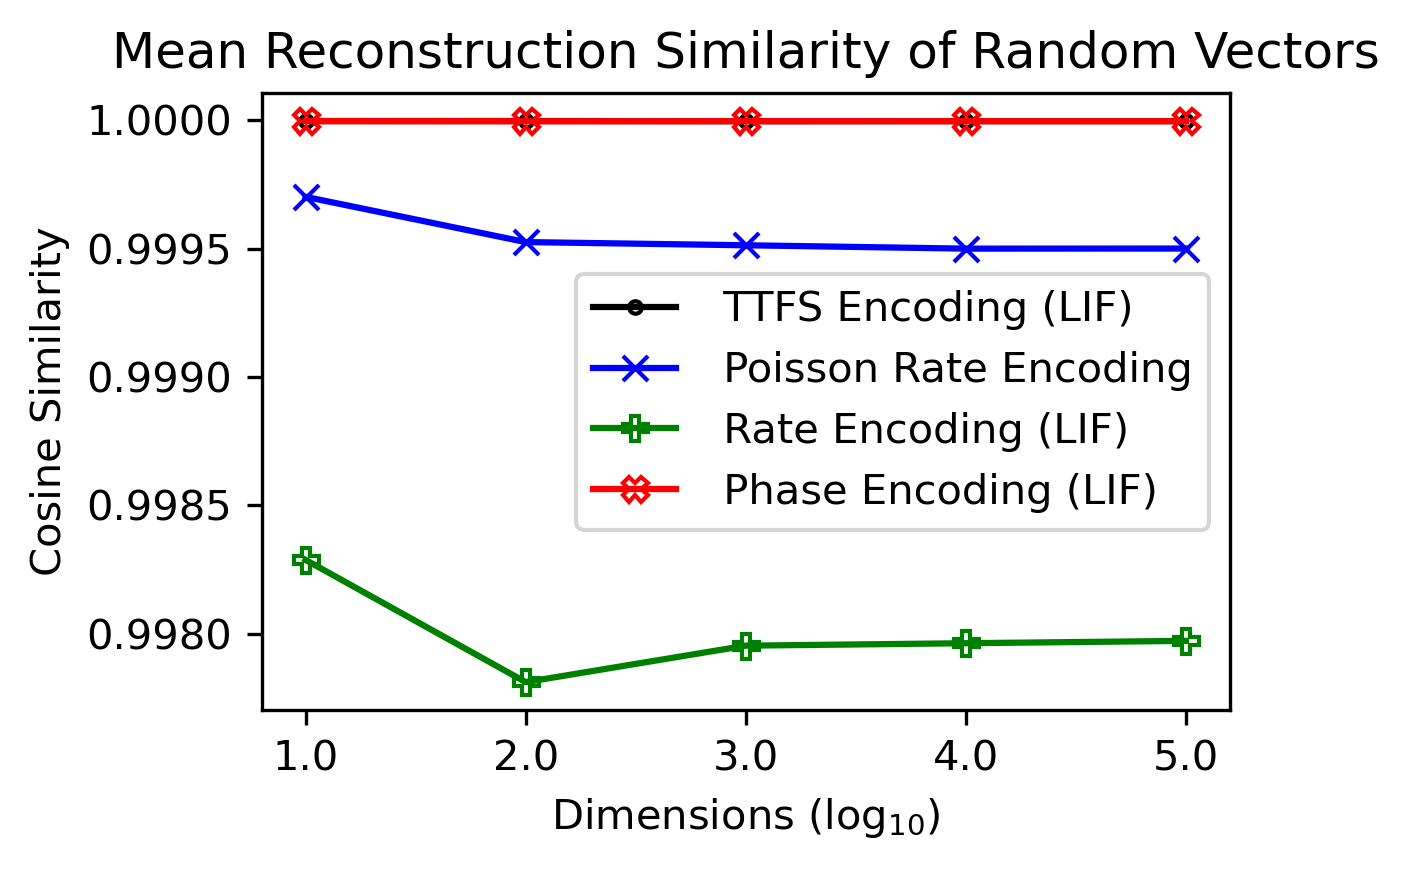

In [67]:
plot_multiple_box_plots(full_rslt_log, "Dimensions (log$_{10}$)", "Cosine Similarity", "Mean Reconstruction Similarity of Random Vectors", False
                        , label_prefix="", figsize=(4.3,3))# x_limits=(-10,10050), y_limits=(0.9995, 1))

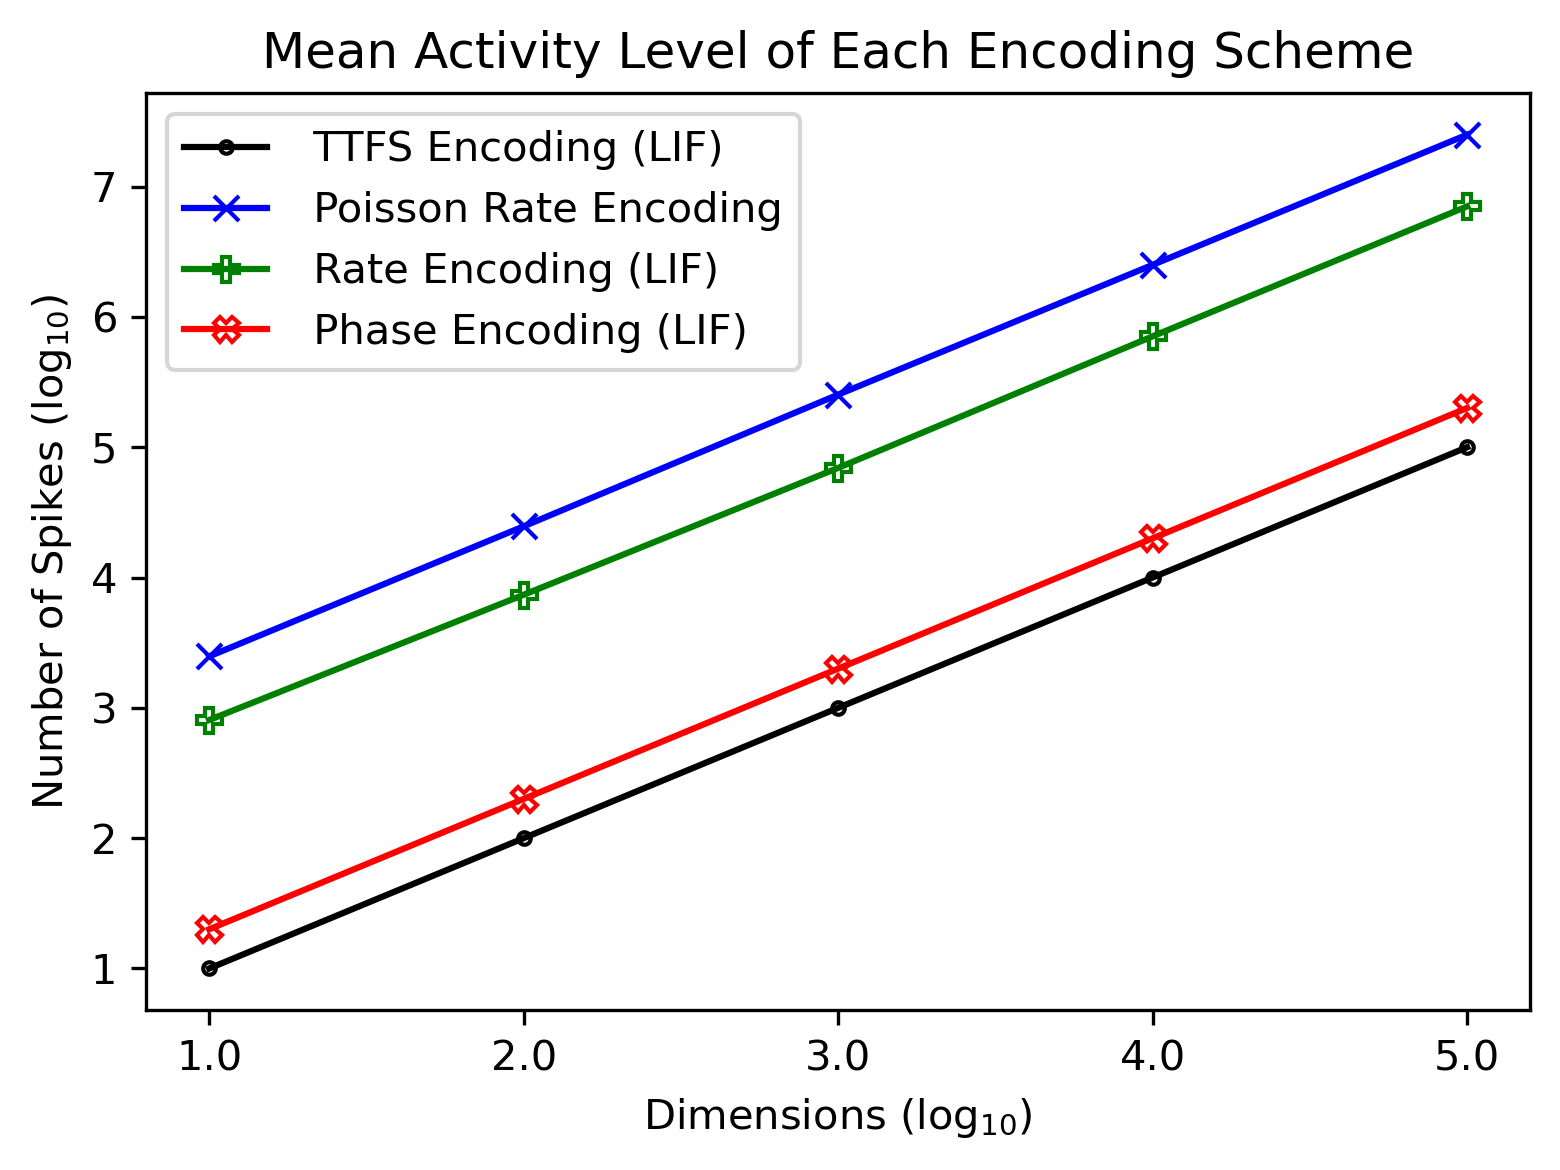

In [68]:
plot_multiple_box_plots(full_actv_log, "Dimensions (log$_{10}$)", "Number of Spikes (log$_{10}$)", "Mean Activity Level of Each Encoding Scheme", False, label_prefix="", figsize=(5.3,4))# x_limits=(-10,10050), y_limits=(0.9995, 1))

In [69]:
full_actv_log

[{'title': 'TTFS Encoding (LIF)',
  'x_values': [1.0, 2.0, 3.0, 4.0, 5.0],
  'y_values': [[1.0], [2.0], [3.0], [4.0], [5.0]]},
 {'title': 'Poisson Rate Encoding',
  'x_values': [1.0, 2.0, 3.0, 4.0, 5.0],
  'y_values': [[3.3951515915045425],
   [4.393013327901293],
   [5.403678051323462],
   [6.399510873779005],
   [7.398337154365004]]},
 {'title': 'Rate Encoding (LIF)',
  'x_values': [1.0, 2.0, 3.0, 4.0, 5.0],
  'y_values': [[2.90687353472207],
   [3.867820908045573],
   [4.84143455811004],
   [5.850970762808312],
   [6.848253239995719]]},
 {'title': 'Phase Encoding (LIF)',
  'x_values': [1.0, 2.0, 3.0, 4.0, 5.0],
  'y_values': [[1.3010299956639813],
   [2.3010299956639813],
   [3.3010299956639813],
   [4.301029995663981],
   [5.301029995663981]]}]

In [70]:
result = []

for rslt, actv in zip(full_rslt_log, full_actv_log):
    title = rslt['title']
    x_values = rslt['x_values']
    y_values = [[r[0] / a[0]] for r, a in zip(rslt['y_values'], actv['y_values'])]
    result.append({'title': title, 'x_values': x_values, 'y_values': y_values})

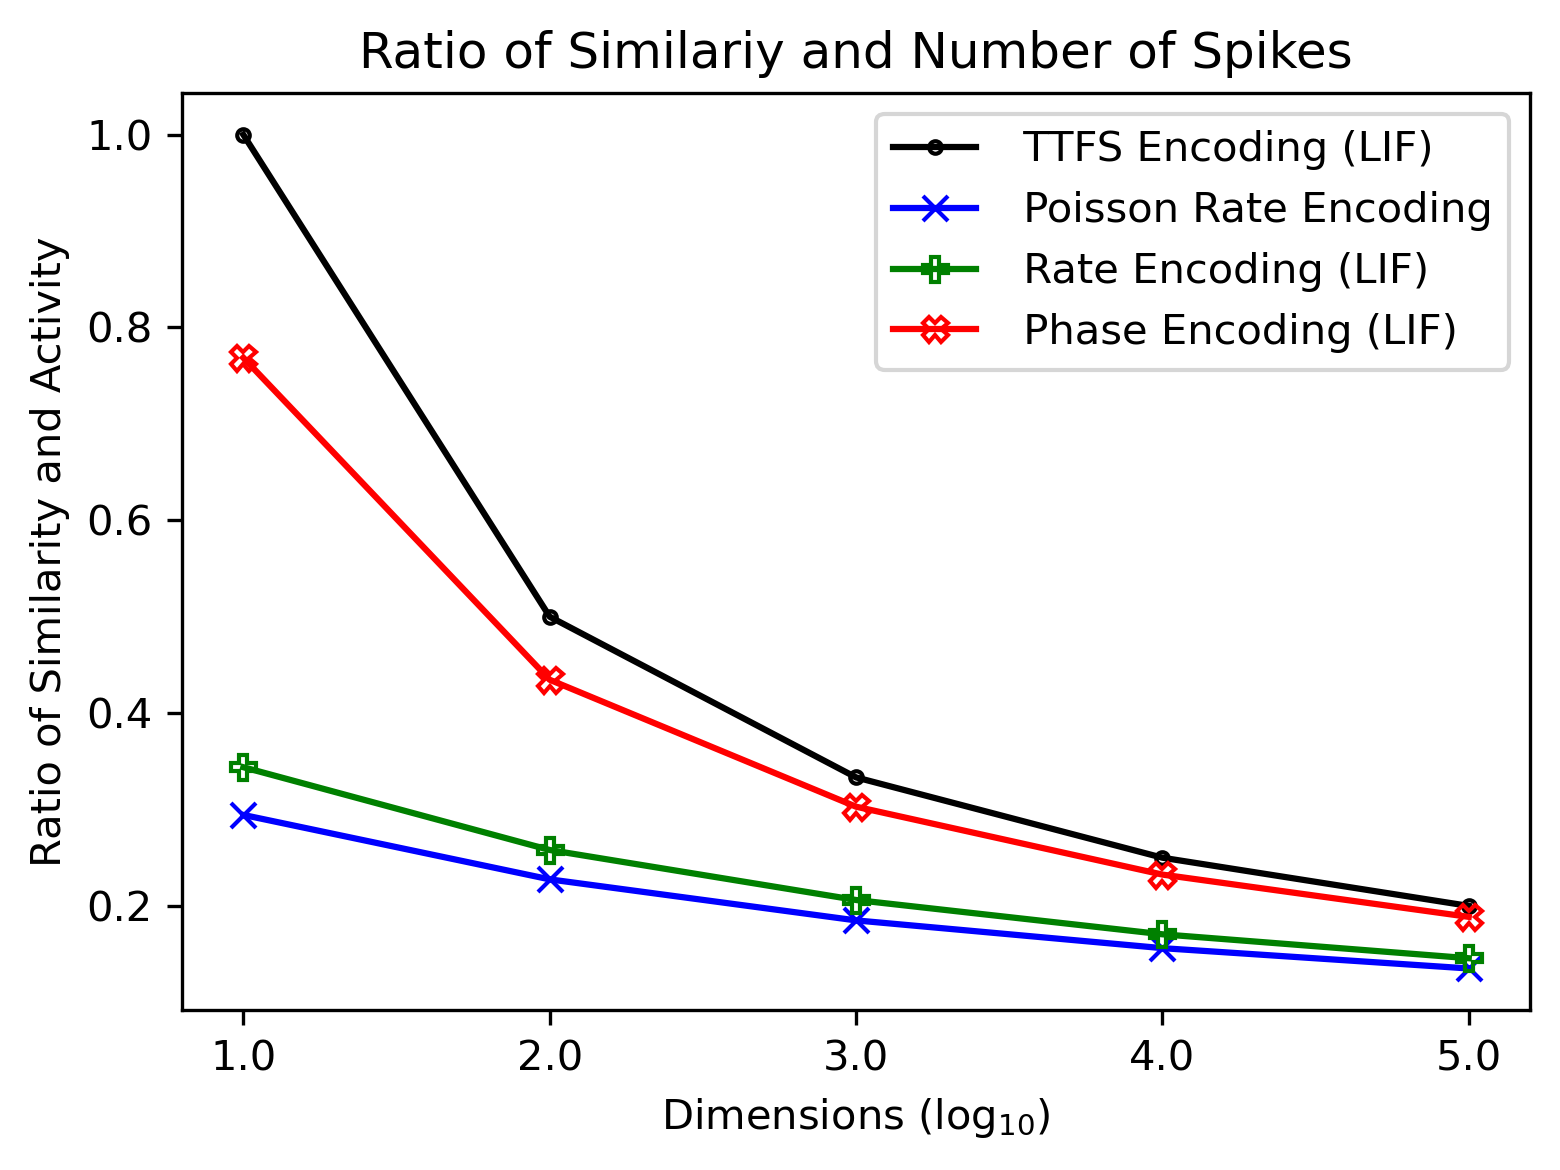

In [71]:
plot_multiple_box_plots(result, "Dimensions (log$_{10}$)", "Ratio of Similarity and Activity", "Ratio of Similariy and Number of Spikes", False, label_prefix="", figsize=(5.3,4))# x_limits=(-10,10050), y_limits=(0.9995, 1))

Not the best meaning 

## Experiment 2: Limit the number of spikes

In [155]:
allowed_spikes = []
default_dim = 1000
percentage_allowed = [0.1, 0.25, 0.5, 0.75, 1]
rv_repeat = 1
sim_time = 500
v_th = 20

for elem in full_actv:
    for i, dim in enumerate(elem["x_values"]):
        if dim == default_dim:
            dit = {}
            dit[ 'title' ] = elem['title']
            dit[ 'max_spikes' ] = elem['y_values'][i][0]
            allowed_spikes.append(dit)
            

In [156]:
allowed_spikes

[{'title': 'TTFS Encoding (LIF)', 'max_spikes': 1000.0},
 {'title': 'Poisson Rate Encoding', 'max_spikes': 253325},
 {'title': 'Rate Encoding (LIF)', 'max_spikes': 69412.0},
 {'title': 'Phase Encoding (LIF)', 'max_spikes': 2000.0}]

In [157]:
for elem in allowed_spikes:
    elem['x_values'] = percentage_allowed
    elem['allowed spike count'] = [int(per * elem['max_spikes']) for per in percentage_allowed]
    

In [158]:
allowed_spikes

[{'title': 'TTFS Encoding (LIF)',
  'max_spikes': 1000.0,
  'x_values': [0.1, 0.25, 0.5, 0.75, 1],
  'allowed spike count': [100, 250, 500, 750, 1000]},
 {'title': 'Poisson Rate Encoding',
  'max_spikes': 253325,
  'x_values': [0.1, 0.25, 0.5, 0.75, 1],
  'allowed spike count': [25332, 63331, 126662, 189993, 253325]},
 {'title': 'Rate Encoding (LIF)',
  'max_spikes': 69412.0,
  'x_values': [0.1, 0.25, 0.5, 0.75, 1],
  'allowed spike count': [6941, 17353, 34706, 52059, 69412]},
 {'title': 'Phase Encoding (LIF)',
  'max_spikes': 2000.0,
  'x_values': [0.1, 0.25, 0.5, 0.75, 1],
  'allowed spike count': [200, 500, 1000, 1500, 2000]}]

In [159]:
limited_rslt = []


### TTFS Encoding (LIF)


In [160]:
sim_rslt = []
for spikes in tqdm(allowed_spikes[0]["allowed spike count"]): # TTFS Encoding (LIF)
    rv_rslt = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, default_dim)
        
        error_percentage = 0.0498 # To make v_th=120 for a nice figure
        # 0.06283 = 2 pi * 1%
        # v_th, _ = lib.set_params_auto(error_percentage,0.06283) # Last param is dummy as we select the timesteps manually here
        lib.set_params_manual(v_th, sim_time)
        
        encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_TTFS(rv1, v_th, sim_time))
        decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        for i in range(sim_time+1):
            decoder.run(condition=RunSteps(num_steps=1), run_cfg=Loihi1SimCfg())
            spike_count = decoder.get_spike_count()
            if np.sum(spike_count) >= spikes:
                break
        
        raw_rslt  = decoder.get_decoded_value()
        
        decoder.stop()

        raw_rslt_convert =  (v_th * 2*math.pi) / (sim_time * raw_rslt)
        
        rslt = cosine_similarity([rv1], [raw_rslt_convert])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
limited_rslt.append( {'title':'TTFS Encoding (LIF)', 'x_values':percentage_allowed, 'y_values':sim_rslt} )


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [01:36<00:00, 19.34s/it]


In [161]:
limited_rslt

[{'title': 'TTFS Encoding (LIF)',
  'x_values': [0.1, 0.25, 0.5, 0.75, 1],
  'y_values': [[0.8986834793690188],
   [0.940132294137562],
   [0.9182354827361446],
   [0.7548050085238982],
   [0.999996235381678]]}]

In [162]:
def limit_spikes(spike_trains, max_spikes):
    # Get the cumulative sum of spikes along the time axis
    cumulative_spikes = np.cumsum(spike_trains, axis=0)
    
    # Create a mask where True indicates spikes that should be kept
    mask = cumulative_spikes <= max_spikes
    
    # Apply the mask to the original spike trains
    limited_spike_trains = spike_trains * mask
    
    return limited_spike_trains

# Example usage:
# spike_trains = ... # Your original 2D array of shape (500, 1000)
# max_spikes = ... # Your constant value
# limited_spike_trains = limit_spikes(spike_trains, max_spikes)

### Rate Encoding (LIF)


In [163]:
sim_rslt = []

''' Calibration to find how many spikes will I get for the Max value. Depends on the timesteps, Vth'''

rv1 = np.array([2*math.pi])

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

spike_count = decoder.get_spike_count()

max_count = spike_count[0]
'''
But calibration is mandatory as after the calibration calculation, it is just a scaling of the spike count vector, which will not 
affect the cosine similarity.
'''

for spikes in tqdm(allowed_spikes[2]["allowed spike count"]): # TTFS Encoding (LIF)
    rv_rslt = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, default_dim)
        
        encoder  = lib.FHRR_Encoder(vec = rv1)
        decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])
        
        encoder.spikes_out.connect(decoder.spikes_a_in)
        
        for i in range(sim_time):
            decoder.run(condition=RunSteps(num_steps=1), run_cfg=Loihi1SimCfg())
            spike_count = decoder.get_spike_count()
            if np.sum(spike_count) >= spikes:
                print(f"Break at {i/sim_time*100}%")
                break
        
        print(np.sum(spike_count))
        decoder.stop()

        decoded_vec = spike_count / max_count * (2*math.pi)
        
        rslt = cosine_similarity([rv1], [decoded_vec])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
# full_rslt.append( {'title':'Rate Encoding (LIF)', 'x_values':dimension_list, 'y_values':sim_rslt} )
limited_rslt.append( {'title':'Rate Encoding (LIF)', 'x_values':percentage_allowed, 'y_values':sim_rslt} )

  0%|          | 0/5 [00:00<?, ?it/s]

Break at 10.4%
7075.0


 20%|██        | 1/5 [00:06<00:25,  6.28s/it]

Break at 24.8%
17371.0


 40%|████      | 2/5 [00:16<00:25,  8.42s/it]

Break at 51.0%
34725.0


 60%|██████    | 3/5 [00:31<00:23, 11.66s/it]

Break at 77.60000000000001%
52221.0


 80%|████████  | 4/5 [00:55<00:16, 16.25s/it]

Break at 96.8%
69655.0


100%|██████████| 5/5 [01:23<00:00, 16.65s/it]


### Poisson Rate Encoding


In [164]:
def limit_spike_count(spike_trains, max_total_spikes):
    total_spikes = 0
    rows, cols = spike_trains.shape
    
    for i in range(rows):
        row_spikes = np.sum(spike_trains[i])
        total_spikes += row_spikes
        
        if total_spikes > max_total_spikes:
            # Zero out the rest of the current row and all subsequent rows
            spike_trains[i, np.sum(spike_trains[i, :]) > total_spikes - max_total_spikes:] = 0
            spike_trains[i+1:, :] = 0
            break
    
    return spike_trains


In [165]:
sim_rslt = []
for spikes in tqdm(allowed_spikes[0]["allowed spike count"]): # TTFS Encoding (LIF)
    rv_rslt = []
    rv_rslt_act = []
    for _ in range(rv_repeat):
        rv1 = np.random.uniform(0, 2 * np.pi, default_dim)
        
        # Encode
        spike_trains, min_val, max_val = rate_encode(rv1, sim_time)
        # print("Spike Trains:\n", spike_trains)
        
        # Limit the spikes
        spike_trains_limited = limit_spike_count(spike_trains, spikes)
        # Decode
        decoded_values = rate_decode(spike_trains_limited, sim_time, min_val, max_val)
        
        rslt = cosine_similarity([rv1], [decoded_values])[0][0]
        # print(rslt)
    
        rv_rslt.append(rslt)
        
    sim_rslt.append(rv_rslt)
    
limited_rslt.append( {'title':'Poisson Rate Encoding', 'x_values':percentage_allowed, 'y_values':sim_rslt} )


  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\21361535\AppData\Local\Temp\ipykernel_12892\900587005.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  spike_trains[i, np.sum(spike_trains[i, :]) > total_spikes - max_total_spikes:] = 0
C:\Users\21361535\AppData\Local\Temp\ipykernel_12892\900587005.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  spike_trains[i, np.sum(spike_trains[i, :]) > total_spikes - max_total_spikes:] = 0
 40%|████      | 2/5 [00:00<00:00, 17.95it/s]C:\Users\21361535\AppData\Local\Temp\ipykernel_12892\900587005.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  spike_trains[i, np.sum(spike_trains[i, :]) > total_spikes - max_total_spikes:] = 0
C:\Users\21361535\AppData\Local\Temp\ipykernel_12892\900587005.py:11: DeprecationWarning: In future, it will be an error for 'np.bool_' scala

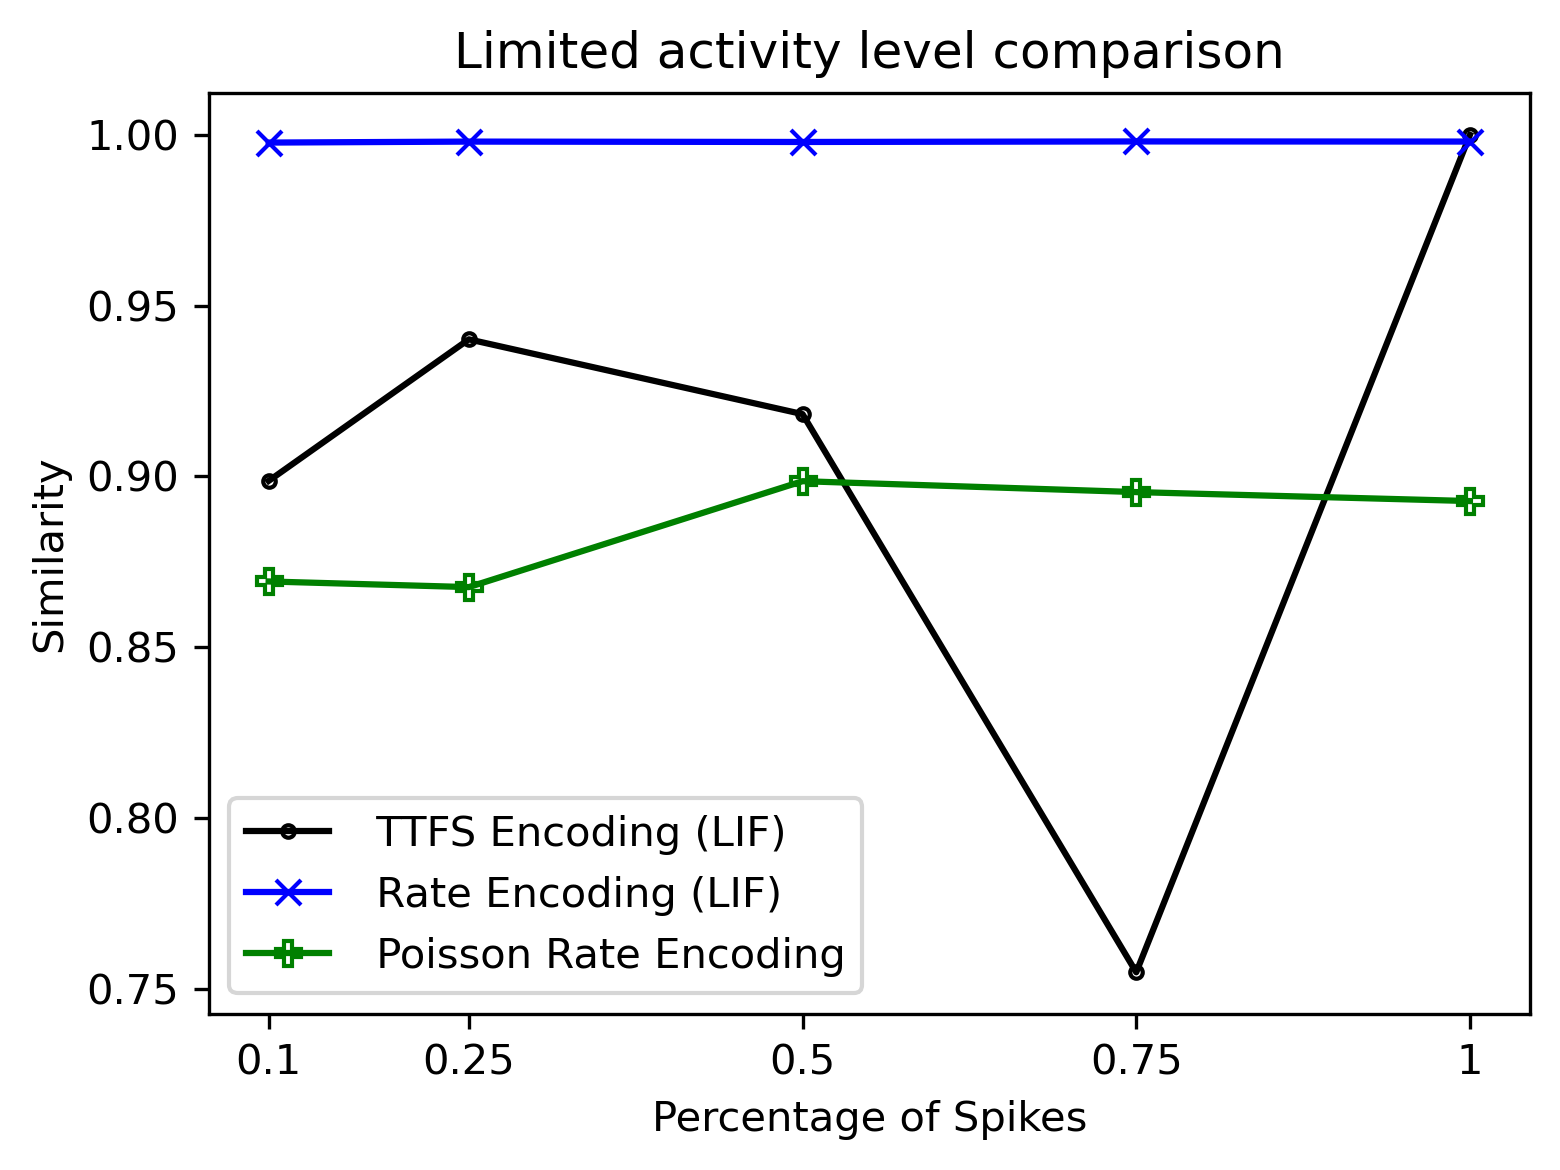

In [166]:
plot_multiple_box_plots(limited_rslt, "Percentage of Spikes", "Similarity", "Limited activity level comparison", False, label_prefix="", figsize=(5.3,4))# x_limits=(-10,10050), y_limits=(0.9995, 1))

In [138]:
# rv1 = np.random.uniform(0, 2 * np.pi, 10)
        
# spike_trains, min_val, max_val = rate_encode(rv1, 10)

# print(spike_trains)


# # Example usage:
# max_spikes = 50  # Set your desired maximum spike count
# limited_spike_trains = limit_spike_count(spike_trains, max_spikes)
# print(limited_spike_trains)
# print(f"Total spikes after limiting: {np.sum(limited_spike_trains)}")
# print(spike_trains.shape)

## Debugging

### Investigate why similarity drops when dim increase 

In [82]:
def add_fixed_percentage_error(arr, percentage):
    """
    Add a fixed percentage of error to each element of a NumPy array.

    Parameters:
    arr (numpy.ndarray): The original array.
    percentage (float): The fixed percentage of error to add (e.g., 10 for 10%).

    Returns:
    numpy.ndarray: The array with added error.
    """
    # Convert percentage to a decimal
    percentage_decimal = percentage / 100.0

    # Determine if the error should be positive or negative for each element
    sign = np.random.choice([-1, 1], size=arr.shape)

    # Calculate the error based on the percentage of each element
    error = sign * percentage_decimal * arr

    # Add the error to the original array
    arr_with_error = arr + error

    return arr_with_error

def add_normal_noise(arr, std_dev):
    """
    Add noise to each element of a NumPy array, where the noise is drawn from a normal distribution
    with the mean equal to each element of the array.

    Parameters:
    arr (numpy.ndarray): The original array.
    std_dev (float): The standard deviation of the normal distribution.

    Returns:
    numpy.ndarray: The array with added noise.
    """
    # Generate noise with mean equal to each element in arr and specified standard deviation
    noise = np.random.normal(loc=arr, scale=std_dev, size=arr.shape)

    # Add the noise to the original array
    arr_with_noise = arr + noise

    return arr_with_noise

In [83]:
full_rslt_theory = []
error_lst = [5]
rv_repeat = 100
dimension_list = [10,100,1000,10000, 100000]#, 1000000, 10000000, 100000000]

In [84]:
for error in error_lst:
    sim_rslt = []
    for dimensions in tqdm(dimension_list):
        rv_rslt = []
        for _ in range(rv_repeat):
            rv1 = np.random.uniform(0, 2 * np.pi, dimensions)
            
            decoded_vec = add_fixed_percentage_error(rv1, error)
            # decoded_vec = add_normal_noise(rv1, 1)
            
            rslt = cosine_similarity([rv1], [decoded_vec])[0][0]
            # print(rslt)
        
            rv_rslt.append(rslt)
            
        sim_rslt.append(rv_rslt)
        # act_rslt.append(rv_rslt_act)
        
    full_rslt_theory.append( {'title': f'Theoretical : {error}%', 'x_values':dimension_list, 'y_values':sim_rslt} )
# full_actv.append( {'title':'Latency Encoding (LIF)', 'x_values':dimension_list, 'y_values':act_rslt} )

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00,  6.03it/s]


In [85]:
full_rslt_theory_log = deepcopy(full_rslt_theory)

In [86]:
for it in full_rslt_theory_log:
    it['x_values'] = [math.log10(dim) for dim in it['x_values']]

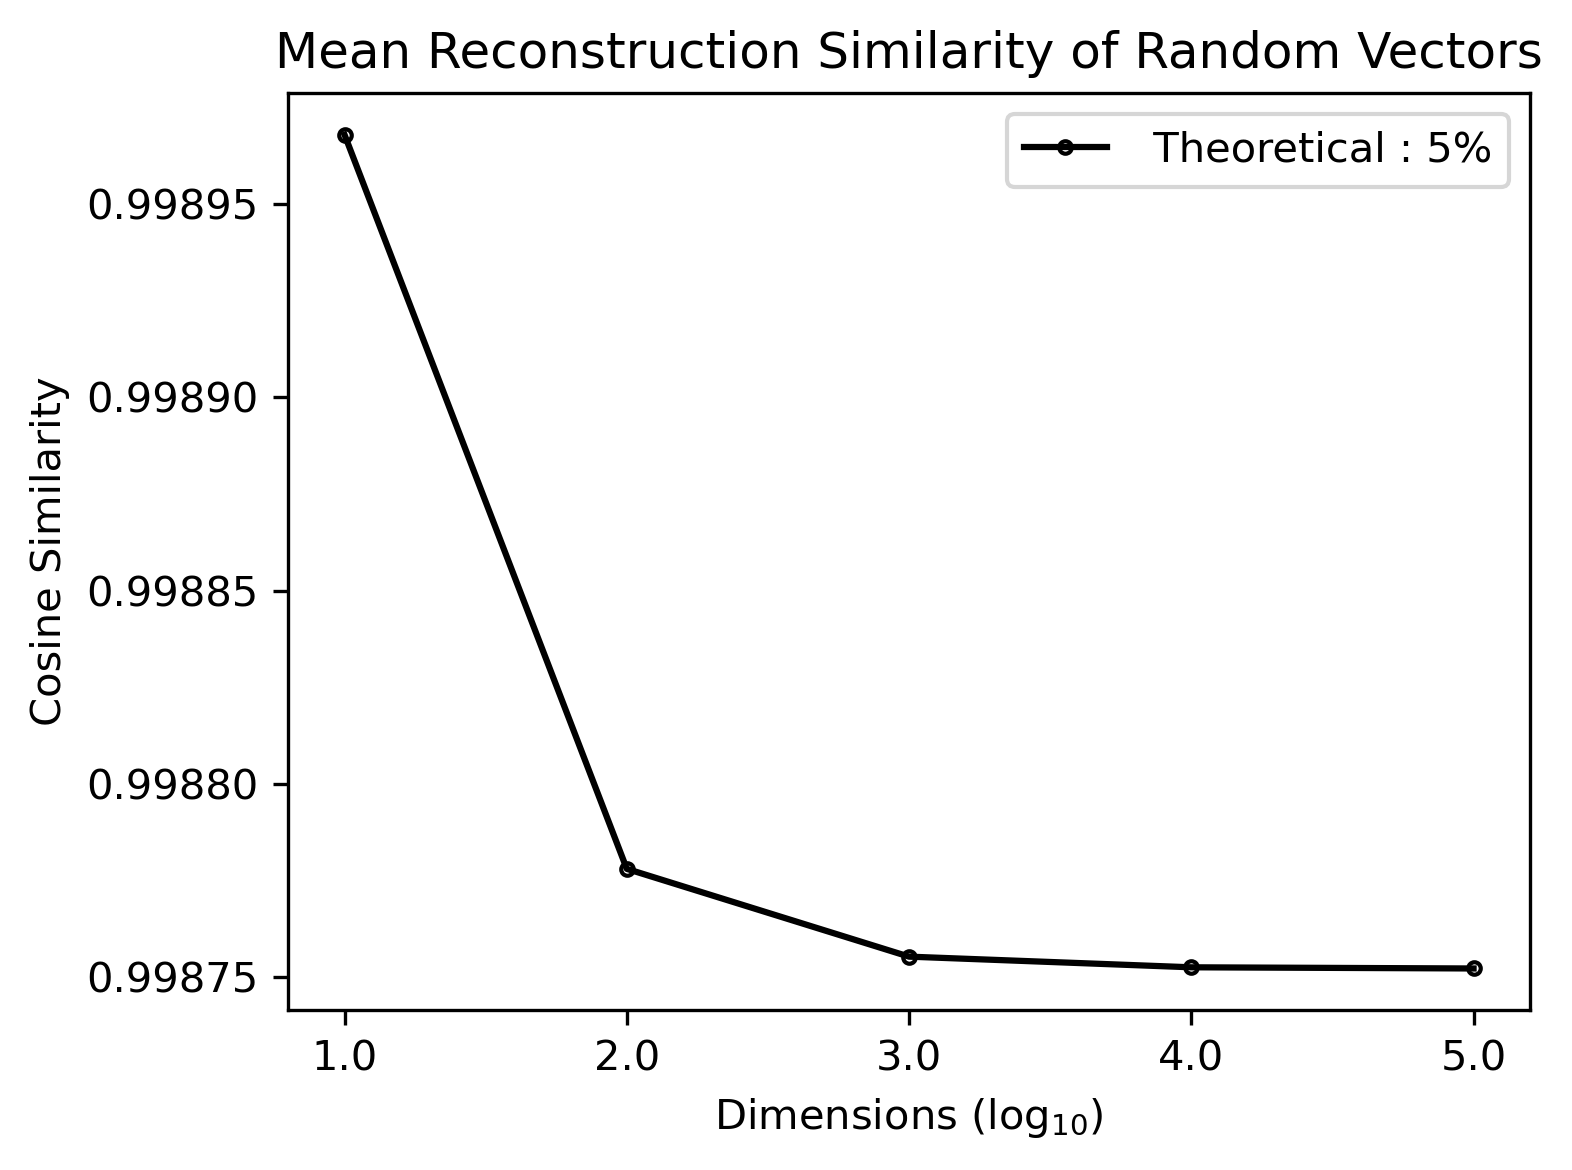

In [87]:
plot_multiple_box_plots(full_rslt_theory_log, "Dimensions (log$_{10}$)", "Cosine Similarity", "Mean Reconstruction Similarity of Random Vectors", False
                        , label_prefix="", figsize=(5.3,4))# x_limits=(-10,10050), y_limits=(0.9995, 1))

In [88]:
# full_rslt_theory_log

### Test the LIF Rate encoding

In [89]:
# sim_time = 2000
# v_th = 120
# rv_repeat = 1
# v_th = 20

# lib.set_params_manual(v_th, sim_time)
# dimensions = 1000

In [90]:
# rv1 = np.random.uniform(0, 2 * np.pi, dimensions)

# encoder  = lib.FHRR_Encoder(vec = rv1)
# decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

# encoder.spikes_out.connect(decoder.spikes_a_in)

# decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

# raw_rslt  = decoder.get_decoded_value()

# spike_count = decoder.get_spike_count()

# decoder.stop()

In [91]:
# rslt = cosine_similarity([rv1], [raw_rslt])[0][0]

In [92]:
# rslt

In [93]:
# rate_decode_vec = (spike_count / sim_time) * (2*math.pi)

### Calibration signal

In [95]:
rv1 = np.array([2*math.pi])

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

spike_count = decoder.get_spike_count()

max_count = spike_count[0]

In [96]:
rv1 = np.random.uniform(0, 2 * np.pi, dimensions)

encoder  = lib.FHRR_Encoder(vec = rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

raw_rslt  = decoder.get_decoded_value()

spike_count = decoder.get_spike_count()

decoder.stop()

In [97]:
decoded_vec = spike_count / max_count * (2*math.pi)

In [98]:
cosine_similarity([rv1], [decoded_vec])[0][0]

0.9979476296973256

In [99]:
cosine_similarity([rv1], [spike_count])[0][0]

0.9979476296973259

### LIF Latency Encoding

In [ ]:
def preprocess_latency_encode_vec(vec, v_th, sim_time):
    # [f(x) if x is not None else '' for x in xs]
    # vec = np.array([v_th * 4  if (2 * math.pi * v_th) / (sim_time * (elem)) > v_th else elem for elem in vec  ])
    return v_th * (2* math.pi) / (vec * sim_time)

In [ ]:
rv1 = np.random.uniform(0, 2 * np.pi, 1000)
# rv1 = np.array([0,0,0,2*math.pi,math.pi,math.pi/2,math.pi/4,0])

latency_rv1 = preprocess_latency_encode_vec_TTFS(rv1, v_th, sim_time)

lib.set_params_manual(v_th, sim_time) #120, 2000

In [ ]:
# Calibration
rv1 = np.array([0])
encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec(rv1, v_th, sim_time))
decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

# spk_count = decoder.get_spike_count()

period_max = decoder.get_spike_period()[0]

decoder.stop()

period_max

C:\Users\21361535\AppData\Local\Temp\ipykernel_17496\1514238994.py:4: RuntimeWarning: divide by zero encountered in divide
  return v_th * (2* math.pi) / (vec * sim_time)


2.0

In [ ]:
# Calibration
rv1 = np.array([2*math.pi/2])

preprocess_latency_encode_vec(rv1, v_th, sim_time)

array([0.12])

In [ ]:
v_th, sim_time

(120, 2000)

In [ ]:
rv1 = np.array([0,0,0,2*math.pi,math.pi,math.pi/2,math.pi/4,0])

latency_rv1 = preprocess_latency_encode_vec(rv1, v_th, sim_time)

encoder  = lib.FHRR_Encoder_Latency(vec = latency_rv1)
decoder  = lib.FHRR_Decoder_Rate(dimension=latency_rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time), run_cfg=Loihi1SimCfg())

spk_count = decoder.get_spike_count()

decoded = decoder.get_decoded_value()

decoder.stop()

print(spk_count)

decoded/decoded_max*(2*math.pi)

C:\Users\21361535\AppData\Local\Temp\ipykernel_17496\1514238994.py:4: RuntimeWarning: divide by zero encountered in divide
  return v_th * (2* math.pi) / (vec * sim_time)


[1. 1. 1. 0. 1. 1. 1. 1.]


NameError: name 'decoded_max' is not defined

In [ ]:
decoded/decoded_max*(2*math.pi)

In [ ]:
decoded

In [ ]:
# rv1 = np.random.uniform(0, 2 * np.pi, 10)
rv1 = np.array([0,0,0,2*math.pi,math.pi,math.pi/2,math.pi/4,0])
# rv1 = np.array([2*math.pi / 8])

In [ ]:
rv1

In [ ]:
v_th, sim_time = 120, 2000

In [ ]:
encoder  = lib.FHRR_Encoder_Latency(vec = preprocess_latency_encode_vec_Phase(rv1, v_th, sim_time))
decoder  = lib.FHRR_Decoder(dimension=rv1.shape[0])

encoder.spikes_out.connect(decoder.spikes_a_in)

decoder.run(condition=RunSteps(num_steps=sim_time+1), run_cfg=Loihi1SimCfg())

decoded = decoder.get_spike_period()

decoder.stop()

decoded_vec = decoded / 835 * (2*math.pi)

rslt = cosine_similarity([rv1], [decoded_vec])[0][0]

### Test the reuse model